In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, FloatSlider

In [3]:
#constantes
mu0 = 1.2566370612e-6 #N/A^2
pi = np.pi

In [7]:
class CurrentSheet:
    def __init__(self, ra, rb, p, current=1):
        self.ra = ra
        self.rb = rb
        self.p = p
        self.pnorm = pnorm = np.linalg.norm(p)
        self.current = current
        self.current_density = current/pnorm
        #calculate the normal which is perpendicular to rb-ra and p
        normal = np.cross(rb-ra, p)
        self.normal = normal/np.linalg.norm(normal)
    def B(self, r2):
        ra, rb, p = self.ra, self.rb, self.p
        pnorm = self.pnorm
        #compute Br
        Br = mu0 * self.current_density
        """
        Compute the magnetic field at a point r2 due to a finite-size current sheet.
        
        Parameters:
            ra (np.array): Start point of the current sheet (3D vector)
            rb (np.array): End point of the current sheet (3D vector)
            p (np.array): Width vector perpendicular to the current sheet
            r2 (np.array): Observation point (3D vector)
            Br (float): Remanent magnetic field (T)
            alpha (float): Aspect ratio of the sheet (w = alpha * |rb - ra|)
        
        Returns:
            np.array: Magnetic field vector at r2
        """

        # Compute fundamental quantities
        C = np.linalg.norm(rb - ra)**2
        A = np.linalg.norm(r2 - ra)**2
        B = np.dot(r2 - ra, rb - ra)

        # Define s-dependent parameters
        def A_s(s):
            return A - 2 * s * np.dot(r2 - ra, p) + pnorm**2 * s**2

        def B_s(s):
            return B  # B(s) is constant

        # Compute integrals numerically over s in [-1/2, 1/2]
        s_vals = np.linspace(-0.5, 0.5, 1000)
        J1 = np.trapz((C - B_s(s_vals)) / np.sqrt(A_s(s_vals) - 2 * B_s(s_vals) + C), s_vals)
        J2 = np.trapz(s_vals * (C - B_s(s_vals)) / np.sqrt(A_s(s_vals) - 2 * B_s(s_vals) + C), s_vals)
        J3 = np.trapz(B_s(s_vals) / np.sqrt(A_s(s_vals)), s_vals)
        J4 = np.trapz(s_vals * B_s(s_vals) / np.sqrt(A_s(s_vals)), s_vals)

        # Correcting for the removal of α using sqrt(C)
        prefactor = (Br * pnorm * np.sqrt(C)) / (4 * np.pi)

        # Compute the magnetic field components
        B_field = prefactor * ((C - B) * J1 + B * J3) * np.cross(rb - ra, r2 - ra) / (A * C - B**2)
        B_field += prefactor * ((C - B) * J2 + B * J4) * np.cross(rb - ra, p) / np.linalg.norm(np.cross(rb - ra, p))

        return B_field

    @property
    def outline(self):
        p, ra,rb = self.p, self.ra, self.rb
        return np.array([ra+p, rb+p, rb-p, ra-p, ra+p])


In [8]:
#create a square of current sheets
current_sheets = []
fondation = list(map(np.array,[(0,-2,0), (0,2,0), (1,1,0), (1,0,0), (0,0,0)]))

for i in range(1):
    a,b = fondation[i], fondation[i+1]
    mid = (a+b)/2
    p_val = np.array([1,0,0])
    current_sheets.append(CurrentSheet(a, b, p_val))

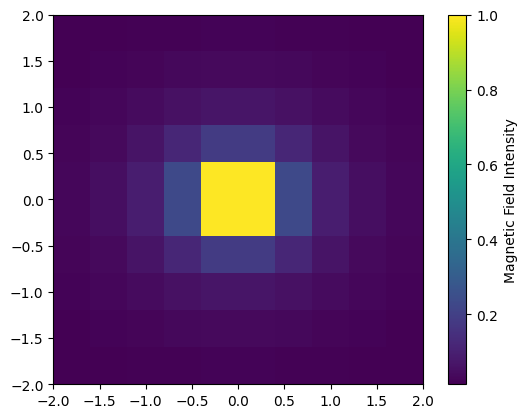

In [14]:
#plot the magnetic field intensity calculated previously
for sheet in current_sheets:
    ra, rb, p = sheet.ra, sheet.rb, sheet.p
    X,Y = np.meshgrid(np.linspace(-40, 40, 10), np.linspace(-40, 40, 10))
    B = np.array([sheet.B(np.array([xi, 0, zi])) for xi, zi in zip(X.flatten(), Y.flatten())])
    B = B.reshape(len(X), len(Y), 3)
    # B2 = np.array([sheet.B(np.array([-xi, -yi, 0])) for xi, yi in zip(X.flatten(), Y.flatten())])
    # B2 = B.reshape(len(X), len(Y), 3)
    # BS = B + B2
    norm = np.linalg.norm(B, axis=2)
    maxnorm = np.max(norm)
    norm /= maxnorm

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.imshow(norm, cmap='viridis', extent=(-2, 2, -2, 2))
plt.colorbar(label='Magnetic Field Intensity')
plt.show()

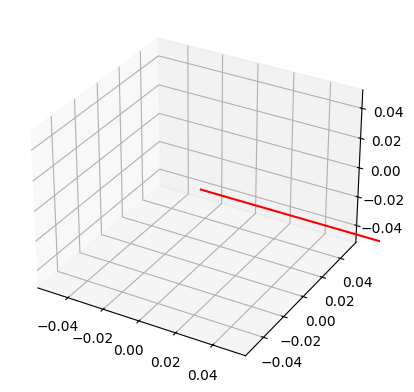

interactive(children=(FloatSlider(value=0.1, description='z', max=1.0, min=-1.0), Output()), _dom_classes=('wi…

[[[ 1.42595960e-07  0.00000000e+00  3.04116369e-06]
  [ 2.45087916e-07  0.00000000e+00  3.97866444e-06]
  [ 4.94393577e-07  0.00000000e+00  5.62415902e-06]
  [ 1.38551516e-06  0.00000000e+00  9.32090058e-06]
  [ 1.07301366e-05  0.00000000e+00  2.38738083e-05]
  [ 1.07301366e-05  0.00000000e+00 -2.38738083e-05]
  [ 1.38551516e-06  0.00000000e+00 -9.32090058e-06]
  [ 4.94393577e-07  0.00000000e+00 -5.62415902e-06]
  [ 2.45087916e-07  0.00000000e+00 -3.97866444e-06]
  [ 1.42595960e-07  0.00000000e+00 -3.04116369e-06]]

 [[ 1.27438201e-07  0.00000000e+00  2.77080998e-06]
  [ 2.22382988e-07  0.00000000e+00  3.67691471e-06]
  [ 4.57325888e-07  0.00000000e+00  5.29638599e-06]
  [ 1.31764018e-06  0.00000000e+00  9.01281478e-06]
  [ 1.04946798e-05  0.00000000e+00  2.34599189e-05]
  [ 1.04946798e-05  0.00000000e+00 -2.34599189e-05]
  [ 1.31764018e-06  0.00000000e+00 -9.01281478e-06]
  [ 4.57325888e-07  0.00000000e+00 -5.29638599e-06]
  [ 2.22382988e-07  0.00000000e+00 -3.67691471e-06]
  [ 1.2743

<Figure size 640x480 with 0 Axes>

In [ ]:
fig1 = plt.figure()
ax = plt.subplot(1,1,1, projection='3d')

ax.quiver(0, 0, 0, 1, 0, 0, color='r')

# Plot the current sheet outline in 3D as full plane
def update_plot(z):
    X,Y = np.meshgrid(np.linspace(-2, 2, 10), np.linspace(-2, 2, 10))
    B = np.array([np.sum([sheet.B(np.array([xi, yi, z])) for sheet in current_sheets], axis=0) for xi, yi in zip(X.flatten(), Y.flatten())])
    B = B.reshape(len(X), len(Y), 3)
    print(B)
    B = B.reshape(len(X), len(Y), 3)

    norm = np.linalg.norm(B, axis=2)
    maxnorm = np.max(norm)
    B = B / maxnorm
    Bx, By, Bz = B[:, :, 0], B[:, :, 1], B[:, :, 2]
    plt.suptitle(f"Max Norm: {maxnorm}")
    print("eee")
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_box_aspect([1, 1, 1])

    # Re-plot the current sheets
    for sheet in current_sheets:
        verts = [sheet.outline[:-1]]
        rect = Poly3DCollection(verts, facecolors="#67597A", edgecolors='#67597A', alpha=0.2)
        ax.add_collection3d(rect)
        mid = (sheet.ra + sheet.rb) / 2
        p_val = sheet.p
        ax.quiver(*mid, *p_val, color='r')
        ax.plot([sheet.ra[0], sheet.rb[0]], [sheet.ra[1], sheet.rb[1]], [sheet.ra[2], sheet.rb[2]], color='g', label="Current Line")
    

    # Re-plot the magnetic field vectors
    ax.quiver(X, Y, z, Bx, By, Bz, length=0.1, normalize=False, color='b')
    fig1.draw(fig1.canvas.get_renderer())

interact(update_plot, z=FloatSlider(value=0.1, min=-1.0, max=1.0, step=0.1))
    
# Create and add the polygon
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#set axes equal
ax.set_xlim([-2, 2])
ax.set_ylim([-2, 2])
ax.set_zlim([-2, 2])

update_plot(z=0.1)

ax.legend()